In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
import pickle

In [2]:
df = pd.read_csv('irrigation_with_weather_data.csv',sep=',',)
df = df.sample(frac=1).reset_index(drop=True)

# Review the data statics 
df.describe()

y_target = df['PSM'] # 1D target vector => soil moisture from next reading => 
#Initial soil moisture captured by first reading-> Evaopration changes -> new soil moisture second reading
#PSM is manually produced soil moisture from next reading

# Data Matrix containing all features excluding the target column "PSM"
x_feature = df.drop(columns=['PSM'])

# convert data frame to numpy
x_feature_numpy = x_feature.to_numpy()
y_target_numpy = y_target.to_numpy()

# split input data in training and testing data 
x_feature_train, x_feature_test, y_target_train, y_target_test = train_test_split(x_feature_numpy, y_target_numpy, test_size=0.2, random_state=43) # shuffles and splits

# Normalised the trainning data and create a model scale to normalize all future data
scaler = MinMaxScaler()
scaler.fit(x_feature_train)
x_feature_train_norm = scaler.transform(x_feature_train)

# Normalise testing data using training model scale
x_feature_test_norm = scaler.transform(x_feature_test)

# Save training model scale as pickle file for future normalisation 
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [3]:
# Support vector machine model with hyper paramater tunning 
regressor = SVR(kernel = 'rbf', C= 10000, gamma=0.0001)
regressor.fit(x_feature_train_norm, y_target_train)

SVR(C=10000, gamma=0.0001)

In [4]:
# predicting and printing training and testing MSE
y_target_train_pred = regressor.predict(x_feature_train_norm)
y_target_test_pred = regressor.predict(x_feature_test_norm)
train_accuracy_str = "Train Loss: %f:" % mean_squared_error(y_target_train, y_target_train_pred)
test_accuracy_str = "Test Loss: %f: " % mean_squared_error(y_target_test, y_target_test_pred)
print("Loss :",train_accuracy_str, test_accuracy_str)

Loss : Train Loss: 0.003812: Test Loss: 0.003744: 


In [5]:
# SVR sfold training model to generate learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    SVR(kernel = 'rbf', C= 10000, gamma=0.0001), x_feature_train_norm, y_target_train)

In [6]:
# save the model to pickle file for future prediction and realtime trainning usages
filename = 'finalized_model.sav'
pickle.dump(regressor, open(filename, 'wb'))

In [7]:
# Trainning MSE score from sfold run
train_scores

array([[0.99999457, 0.99999497, 0.99999497, 0.99999497, 0.99999497],
       [0.99999572, 0.99999585, 0.99999594, 0.99999594, 0.99999594],
       [0.99999589, 0.99999604, 0.99999599, 0.99999605, 0.99999605],
       [0.99999613, 0.99999627, 0.9999962 , 0.9999962 , 0.99999612],
       [0.9999963 , 0.99999625, 0.99999632, 0.99999621, 0.99999632]])

In [8]:
# validation MSE score from sfold run
valid_scores

array([[0.99999463, 0.99999474, 0.99999485, 0.99999476, 0.99999487],
       [0.99999574, 0.99999578, 0.99999596, 0.99999599, 0.9999959 ],
       [0.99999592, 0.99999599, 0.99999601, 0.99999611, 0.99999602],
       [0.99999614, 0.99999623, 0.9999962 , 0.99999626, 0.99999606],
       [0.99999631, 0.99999622, 0.99999634, 0.99999628, 0.99999625]])

In [9]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -valid_scores.mean(axis = 1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(valid_scores_mean, index = train_sizes))

Mean training scores

 874     0.999995
2841    0.999996
4808    0.999996
6775    0.999996
8742    0.999996
dtype: float64

 --------------------

Mean validation scores

 874     0.999995
2841    0.999996
4808    0.999996
6775    0.999996
8742    0.999996
dtype: float64


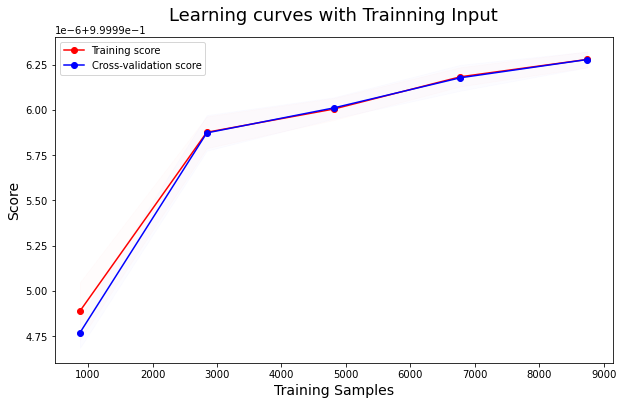

In [10]:
fig, (loss_plot) = plt.subplots(1,1,figsize=(10,6))
ax = plt.axes()
ax.set_facecolor("white")
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training Samples', fontsize = 14)
plt.title('Learning curves with Trainning Input', fontsize = 18, y = 1.03)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.01,
                     color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.01, color="b")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="b",
             label="Cross-validation score")

plt.legend(loc="best")